# Evaluation and Error Analysis

This notebook (actually, only the second part) needs to be run twice, once for the teller and once for the drawer.

In [1]:
import os
import sys
from pathlib import Path

sys.path.append('..')

import csv
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import normalize

from icr.structs.game import Game

In [2]:
sns.set_theme()
pd.options.display.max_rows = 999

In [3]:
OUTPUT_DIR = Path('../outputs')

In [4]:
def retrieve_outputs(folder):
    """Get the outputs for the validation set (at best validation epoch) and the test."""
    with open(folder / 'config.json', 'r') as f:
        config = json.load(f)
    with open(folder / 'best-epoch.txt', 'r') as f:
        best_epoch = int(f.read())
    best_val_outputs_path = Path(folder / f'val_{best_epoch}.csv')
    val_outputs = pd.read_csv(best_val_outputs_path, sep=',')
    test_outputs_path = Path(folder / f'test_{best_epoch}.csv')
    test_outputs = pd.read_csv(test_outputs_path, sep=',')    
    return config, best_epoch, val_outputs, test_outputs

def split_outputs(outputs):
    """Split the datafram into its columns."""
    game_ids = outputs['game_id']
    turns = outputs['turn']
    labels = outputs['label']
    predictions = outputs['pred']
    probs = outputs['prob']
    return game_ids, turns, labels, predictions, probs

def get_metrics(info):
    """Compute macro-F1 and average precision score for validation and test sets."""
    results = {}
    for split in ('val', 'test'):
    
        game_ids, turns, labels, predictions, probs = split_outputs(info[f'{split}_outputs']) 
        macro_f1 = metrics.f1_score(labels, predictions, average='macro')
        avp = metrics.average_precision_score(labels, probs)
        results[split] = {'avp': avp, 'macro_f1': macro_f1}
    
    return results

Read all output files. We get the configuration and the outputs at the best validation epoch:

In [5]:
output_directories = []
for filename in os.listdir(OUTPUT_DIR):
    f = os.path.join(OUTPUT_DIR, filename)
    if os.path.isdir(f):
        output_directories.append(f)

experiments = {}
for folder in output_directories:
    config, best_epoch, val_outputs, test_outputs = retrieve_outputs(Path(folder))
    # one experiment was run for 200 epochs, to make sure the model can overfit the training data
    # we don't need it here
    if config['n_epochs'] == 200:
        continue
    experiments[folder] = {'config': config, 'best_epoch': best_epoch, 
                           'val_outputs': val_outputs, 'test_outputs': test_outputs}

assert len(experiments) == 12

### Table 5: Main results

In [6]:
main_results = {}
n = 0
for path, info in experiments.items():
    if (info['config']['no_msg'] 
        or info['config']['no_context'] 
        or info['config']['no_image']
        or info['config']['text_pretrained'] != 'all-mpnet-base-v2'):
        continue
    task = info['config']['task']
    main_results[task] = get_metrics(info)
    main_results[task]['path'] = path
    n += 1

assert n == 2

In [7]:
latex_table = ''

for split in ('val', 'test'):
    avp = main_results['drawer'][split]['avp']
    macro_f1 = main_results['drawer'][split]['macro_f1']
    latex_table += f'model & {split} & {avp:.5f} & {macro_f1:.5f}'
    
    avp = main_results['teller'][split]['avp']
    macro_f1 = main_results['teller'][split]['macro_f1']
    latex_table += f' & {avp:.5f} & {macro_f1:.5f} \\\\ \n'

print(latex_table)

model & val & 0.39985 & 0.66265 & 0.99126 & 0.96909 \\ 
model & test & 0.34734 & 0.64512 & 0.98885 & 0.96880 \\ 



### Table 6: Ablation

In [8]:
ablation_results = {'teller': {}, 'drawer': {}}
n = 0
for path, info in experiments.items():
    task = info['config']['task']
    # last message removed 
    if info['config']['no_msg'] and not info['config']['no_context'] and not info['config']['no_image']:
        ablation_results[task]['no_message'] = get_metrics(info)
        ablation_results[task]['no_message']['path'] = path
        n += 1
    # context removed
    elif not info['config']['no_msg'] and info['config']['no_context'] and not info['config']['no_image']:
        ablation_results[task]['no_context'] = get_metrics(info)
        ablation_results[task]['no_context']['path'] = path
        n += 1
    # image removed
    elif not info['config']['no_msg'] and not info['config']['no_context'] and info['config']['no_image']:
        ablation_results[task]['no_image'] = get_metrics(info)
        ablation_results[task]['no_image']['path'] = path
        n += 1

assert n == 6

In [9]:
latex_table = ''

for no_input in ('no_image', 'no_message', 'no_context'):
    for split in ('val', 'test'):
        avp = ablation_results['drawer'][no_input][split]['avp']
        macro_f1 = ablation_results['drawer'][no_input][split]['macro_f1']
        latex_table += f'{no_input} & {split} & {avp:.5f} & {macro_f1:.5f}'

        avp = ablation_results['teller'][no_input][split]['avp']
        macro_f1 = ablation_results['teller'][no_input][split]['macro_f1']
        latex_table += f' & {avp:.5f} & {macro_f1:.5f} \\\\ \n\n'

print(latex_table)

no_image & val & 0.36686 & 0.64966 & 0.99260 & 0.97414 \\ 

no_image & test & 0.32081 & 0.63499 & 0.98814 & 0.96924 \\ 

no_message & val & 0.34977 & 0.64125 & 0.33899 & 0.64064 \\ 

no_message & test & 0.30804 & 0.63501 & 0.28808 & 0.61333 \\ 

no_context & val & 0.29031 & 0.60817 & 0.99232 & 0.97622 \\ 

no_context & test & 0.26490 & 0.59785 & 0.98865 & 0.97069 \\ 




Same table as above, using differences to main experiment:

In [10]:
latex_table = ''

for no_input in ('no_image', 'no_message', 'no_context'):
    for split in ('val', 'test'):

        avp = ablation_results['drawer'][no_input][split]['avp']
        macro_f1 = ablation_results['drawer'][no_input][split]['macro_f1']
        diff_avp = avp - main_results['drawer'][split]['avp']
        diff_macro_f1 = macro_f1 - main_results['drawer'][split]['macro_f1']
        latex_table += f'{no_input} & {split} & {diff_avp:.5f} & {diff_macro_f1:.5f}'

        avp = ablation_results['teller'][no_input][split]['avp']
        macro_f1 = ablation_results['teller'][no_input][split]['macro_f1']
        diff_avp = avp - main_results['teller'][split]['avp']
        diff_macro_f1 = macro_f1 - main_results['teller'][split]['macro_f1']
        latex_table += f' & {diff_avp:.5f} & {diff_macro_f1:.5f} \\\\ \n\n'

print(latex_table)

no_image & val & -0.03299 & -0.01299 & 0.00134 & 0.00505 \\ 

no_image & test & -0.02653 & -0.01013 & -0.00072 & 0.00044 \\ 

no_message & val & -0.05007 & -0.02140 & -0.65227 & -0.32845 \\ 

no_message & test & -0.03930 & -0.01011 & -0.70077 & -0.35547 \\ 

no_context & val & -0.10954 & -0.05447 & 0.00105 & 0.00713 \\ 

no_context & test & -0.08244 & -0.04726 & -0.00021 & 0.00189 \\ 




In [11]:
subablation_results = {'teller': {}, 'drawer': {}}
n = 0
for path, info in experiments.items():
    if info['config']['text_pretrained'] != 'all-mpnet-base-v2':
        which = info['config']['text_pretrained'].split('v2_')[1]
        subablation_results[info['config']['task']][which] = get_metrics(info)
        subablation_results[info['config']['task']][which]['path'] = path
        n += 1

assert n == 4

In [12]:
latex_table = ''

for which in ('no-teller', 'no-drawer'):
    for split in ('val', 'test'):
        
        avp = subablation_results['drawer'][which][split]['avp']
        macro_f1 = subablation_results['drawer'][which][split]['macro_f1']
        latex_table += f'{which} & {split} & {avp:.5f} & {macro_f1:.5f}'

        avp = subablation_results['teller'][which][split]['avp']
        macro_f1 = subablation_results['teller'][which][split]['macro_f1']
        latex_table += f' & {avp:.5f} & {macro_f1:.5f} \\\\ \n\n'

print(latex_table)

no-teller & val & 0.39836 & 0.66293 & 0.98999 & 0.96856 \\ 

no-teller & test & 0.39234 & 0.65820 & 0.98864 & 0.96727 \\ 

no-drawer & val & 0.31266 & 0.60778 & 0.99080 & 0.97616 \\ 

no-drawer & test & 0.26853 & 0.59284 & 0.98994 & 0.97358 \\ 




Again, same table using differences to main results:

In [13]:
latex_table = ''

for which in ('no-teller', 'no-drawer'):
    for split in ('val', 'test'):
        
        avp = subablation_results['drawer'][which][split]['avp']
        macro_f1 = subablation_results['drawer'][which][split]['macro_f1']
        diff_avp = avp - main_results['drawer'][split]['avp']
        diff_macro_f1 = macro_f1 - main_results['drawer'][split]['macro_f1']
        latex_table += f'{which} & {split} & {diff_avp:.5f} & {diff_macro_f1:.5f}'

        avp = subablation_results['teller'][which][split]['avp']
        macro_f1 = subablation_results['teller'][which][split]['macro_f1']
        diff_avp = avp - main_results['teller'][split]['avp']
        diff_macro_f1 = macro_f1 - main_results['teller'][split]['macro_f1']
        latex_table += f' & {diff_avp:.5f} & {diff_macro_f1:.5f} \\\\ \n\n'

print(latex_table)

no-teller & val & -0.00149 & 0.00029 & -0.00127 & -0.00054 \\ 

no-teller & test & 0.04500 & 0.01308 & -0.00021 & -0.00153 \\ 

no-drawer & val & -0.08719 & -0.05487 & -0.00046 & 0.00706 \\ 

no-drawer & test & -0.07881 & -0.05228 & 0.00109 & 0.00479 \\ 




## Detailed analysis on Task 1, validation set

In [29]:
CODRAW_PATH = '../data/CoDraw-master/dataset/CoDraw_1_0.json'
ANNOTATION_PATH =  '../data/cr_anno_adjudication/data_adju.tsv'
ICR_COLUMN = 'is CR? v2'

INCLUDE_PEEK = True
SPLIT = 'val'
TASK = 'teller' # 'drawer'

In [30]:
with open(CODRAW_PATH, 'r') as f:
    codraw = json.load(f)
    
annotated = pd.read_csv(ANNOTATION_PATH, sep='\t')
sentences = annotated['drawer\'s utterance']
icr_labels = annotated[ICR_COLUMN]
icrs = set([sent for sent, label in zip(sentences, icr_labels) if label == 1])

In [31]:
games = {}
for name, infos in codraw['data'].items():
    if SPLIT in name:
        game_idx = int(name.split('_')[1])
        game = Game(name, infos, icrs, quick_load=True, include_peek=INCLUDE_PEEK)
        games[game_idx] = game

assert len(games) == 1002

In [32]:
path = main_results[TASK]['path']
config, best_epoch, val_outputs, test_outputs = retrieve_outputs(Path(path))
game_ids, turns, labels, predictions, probs = split_outputs(val_outputs)

In [33]:
positive = len([x for x in labels if x == 1])
negative = len([x for x in labels if x == 0])

print(positive / (positive + negative))

0.11926367643246046


Various metrics:

In [34]:
accuracy = metrics.accuracy_score(labels, predictions)
print('Accuracy: ', accuracy)

balanced_accuracy = metrics.balanced_accuracy_score(labels, predictions)
print('Balanced accuracy: ', balanced_accuracy)

macro_f1 = metrics.f1_score(labels, predictions, average='macro')
print('macro F1: ', macro_f1)

f1 = metrics.f1_score(labels, predictions, average='binary')
print('F1: ', f1)

brier = metrics.brier_score_loss(labels, probs)
print('Brier score: ', brier)

avp = metrics.average_precision_score(labels, probs)
print('Average precision: ', avp)

fpr, tpr, thresholds_roc = metrics.roc_curve(labels, probs, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print('AUC ROC: ', roc_auc)

precisions, recalls, thresholds_pr = metrics.precision_recall_curve(labels, probs)

confusion = metrics.confusion_matrix(labels, predictions)
print('Confusion matrix:\n', confusion)

print('\nClassification report\n', metrics.classification_report(labels, predictions))

Accuracy:  0.9865180191858958
Balanced accuracy:  0.9871774647707057
macro F1:  0.9690947084372876
F1:  0.9458896982310094
Brier score:  0.010372102766169374
Average precision:  0.9912618471877199
AUC ROC:  0.9988924050632911
Confusion matrix:
 [[6701   93]
 [  11  909]]

Classification report
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      6794
           1       0.91      0.99      0.95       920

    accuracy                           0.99      7714
   macro avg       0.95      0.99      0.97      7714
weighted avg       0.99      0.99      0.99      7714



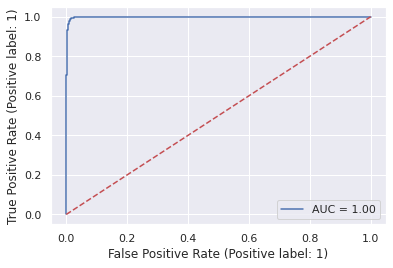

In [35]:
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, pos_label=1)
display.plot()
display.ax_.plot([0, 1], [0, 1], 'r--')

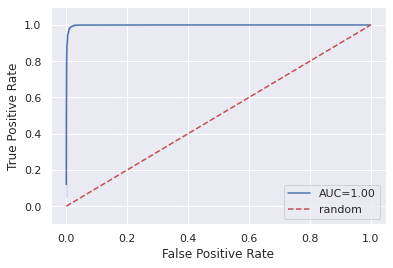

In [36]:
sns.lineplot(x=fpr, y=tpr, label=f'AUC={roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--', label='random')
plt.xlabel('False Positive Rate')
plt.ylim(-0.1, 1.1)
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig(f'figures/roc_curve_{TASK}_{SPLIT}.pdf', bbox_inches='tight')
plt.show()

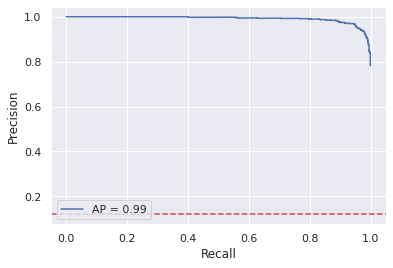

In [37]:
display = metrics.PrecisionRecallDisplay(precisions, recalls, average_precision=avp)
display.plot()

rand_line = positive / (positive + negative)
display.ax_.axhline(rand_line, color='r', ls='--')

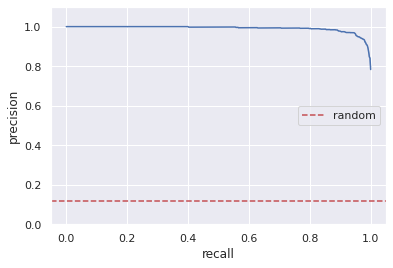

In [38]:
sns.lineplot(x=recalls, y=precisions)
rand_line = positive / (positive + negative)
plt.axhline(rand_line, color='r', ls='--', label='random')
plt.xlabel('recall')
plt.ylim(0, 1.1)
plt.ylabel('precision')
plt.legend()
plt.savefig(f'figures/precrec_curve_{TASK}_{SPLIT}.pdf', bbox_inches='tight')
plt.show()

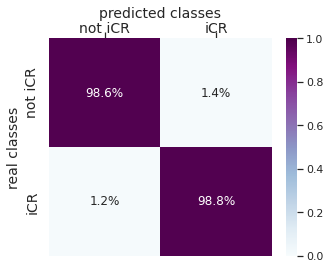

In [39]:
cm = normalize(confusion, axis=1, norm='l1')
df_cm = pd.DataFrame(cm, index = ['not iCR', 'iCR'], columns = ['not iCR', 'iCR'])

f, ax = plt.subplots(1, 1, figsize=(5, 4))
custom_palette = sns.color_palette("BuPu", as_cmap=True)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
sns.heatmap(df_cm, annot=True, fmt = '.1%', vmin=0, vmax=1, cmap=custom_palette, annot_kws={"fontsize":12}, ax=ax)
ax.set_yticklabels(labels=ax.get_yticklabels(), va='center', rotation=90, fontsize=14)
ax.set_xticklabels(labels=ax.get_xticklabels(), va='center', rotation=0, fontsize=14)

ax.set_xlabel('predicted classes', fontsize=14)
ax.set_ylabel('real classes', fontsize=14)

plt.show()

Break down results by turn:

In [40]:
preds_by_turn = {}

for i in range(len(val_outputs)):
    if turns[i] not in preds_by_turn:
        preds_by_turn[turns[i]] = {'preds': [], 'labels': [], 'probs': []}
    preds_by_turn[turns[i]]['preds'].append(predictions[i])
    preds_by_turn[turns[i]]['labels'].append(labels[i])
    preds_by_turn[turns[i]]['probs'].append(probs[i])

In [41]:
macro_f1_scores = []
binary_f1_scores = []
accs = []
balanced_accs = []
avps = []
roc_aucs = []
precisions = []
recalls = []

for i in range(max(preds_by_turn.keys())):
    
    labels = preds_by_turn[i]['labels']
    predictions = preds_by_turn[i]['preds']
    probs = preds_by_turn[i]['probs']
    
    print('\n\n STATS FOR TURN ', i, '\n')
    
    accs.append(metrics.accuracy_score(labels, predictions))
    balanced_accs.append(metrics.balanced_accuracy_score(labels, predictions))
    macro_f1_scores.append(metrics.f1_score(labels, predictions, average='macro'))
    binary_f1_scores.append(metrics.f1_score(labels, predictions, average='binary'))

    print('\nClassification report\n', metrics.classification_report(labels, predictions))

    avps.append(metrics.average_precision_score(labels, probs))
    fpr, tpr, thresholds_roc = metrics.roc_curve(labels, probs, pos_label=1)
    roc_aucs.append(metrics.auc(fpr, tpr))

    precisions.append(metrics.precision_score(labels, predictions))
    recalls.append(metrics.recall_score(labels, predictions))



 STATS FOR TURN  0 


Classification report
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       959
           1       0.88      1.00      0.93        43

    accuracy                           0.99      1002
   macro avg       0.94      1.00      0.97      1002
weighted avg       0.99      0.99      0.99      1002



 STATS FOR TURN  1 


Classification report
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       860
           1       0.92      0.98      0.95       142

    accuracy                           0.99      1002
   macro avg       0.96      0.98      0.97      1002
weighted avg       0.99      0.99      0.99      1002



 STATS FOR TURN  2 


Classification report
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       820
           1       0.93      1.00      0.97       182

    accuracy                           0.

In [42]:
turn_indexes = list(range(max(preds_by_turn.keys())))
n_obs = [len(preds_by_turn[i]['labels']) for i in turn_indexes]
n_obs

[1002,
 1002,
 1002,
 999,
 940,
 804,
 627,
 451,
 321,
 213,
 127,
 85,
 55,
 35,
 23,
 15,
 10,
 2]

In [43]:
if TASK == 'drawer':
    sns.scatterplot(x=turn_indexes, y=avps, hue=n_obs, size=n_obs, sizes=(1, 500), palette='viridis')
    plt.xlabel('dialogue round')
    plt.ylabel('average precision')
    plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.xticks(turn_indexes)
    plt.legend(loc ='lower right')
    plt.savefig(f'figures/avp_per_round_{TASK}val.pdf', bbox_inches='tight')
    plt.show()